In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from qdax.core.cmaes import CMAES

In [3]:
# jax.config.update('jax_disable_jit', True)

### Define fitness function

In [4]:
fitness_func = lambda x: -jnp.sum((x - 5.0) * (x - 5.0), axis=-1)

In [5]:
num_iterations = 700 # 70000 #70000 #10000
num_dimensions = 2 #100 #1000 #@param {type:"integer"} # try 20 and 100
grid_shape = (500, 500) # (500, 500) 
batch_size = 500 #@param {type:"integer"}
sigma_g = 3. # 0.5 #@param {type:"number"}
minval = -5.12
num_best = 250 #36

def rastrigin_scoring(x: jnp.ndarray):
    first_term = 10 * x.shape[-1]
    second_term = jnp.sum((x + minval * 0.4) ** 2 - 10 * jnp.cos(2 * jnp.pi * (x + minval * 0.4)))
    return -(first_term + second_term)
#     return (first_term + second_term)

fitness_func = jax.vmap(rastrigin_scoring)

### Instantiate CMA-ES object

In [6]:
cmaes = CMAES(
    population_size=batch_size,
    num_best=num_best,
    search_dim=num_dimensions, #2, 
    fitness_function=fitness_func,
    mean_init=jnp.zeros((num_dimensions,)), #jnp.asarray([-1.0, -1.0]),
    init_sigma=sigma_g, #1.0,
    init_step_size=0.5 #0.5,
)

### Initialization

In [7]:
state = cmaes.init()
key = jax.random.PRNGKey(0)

In [8]:
cmaes._weights

DeviceArray([2.2378536e-02, 1.9570220e-02, 1.7927460e-02, 1.6761903e-02,
             1.5857827e-02, 1.5119144e-02, 1.4494595e-02, 1.3953587e-02,
             1.3476384e-02, 1.3049511e-02, 1.2663358e-02, 1.2310827e-02,
             1.1986531e-02, 1.1686279e-02, 1.1406751e-02, 1.1145271e-02,
             1.0899648e-02, 1.0668068e-02, 1.0449013e-02, 1.0241196e-02,
             1.0043520e-02, 9.8550413e-03, 9.6749440e-03, 9.5025115e-03,
             9.3371188e-03, 9.1782156e-03, 9.0253083e-03, 8.8779628e-03,
             8.7357890e-03, 8.5984357e-03, 8.4655853e-03, 8.3369548e-03,
             8.2122823e-03, 8.0913315e-03, 7.9738880e-03, 7.8597516e-03,
             7.7487431e-03, 7.6406966e-03, 7.5354557e-03, 7.4328789e-03,
             7.3328358e-03, 7.2352039e-03, 7.1398686e-03, 7.0467256e-03,
             6.9556758e-03, 6.8666274e-03, 6.7794942e-03, 6.6941953e-03,
             6.6106548e-03, 6.5288031e-03, 6.4485720e-03, 6.3698990e-03,
             6.2927241e-03, 6.2169922e-03, 6.142649

### Iterations

In [9]:
%%time

means = [state.mean]
covs = [state.cov_matrix]

for _ in range(num_iterations):
    
    samples, key = cmaes.sample(state, key)
#     state = cmaes.update(state, samples)

    fitnesses = -fitness_func(samples)
    idx_sorted = jnp.argsort(fitnesses)
    sorted_candidates = samples[idx_sorted[: num_best]]

    state = cmaes.update_state(state, sorted_candidates)
    
    means.append(state.mean)
    covs.append(state.cov_matrix)

Cov:  Traced<ShapedArray(float32[2,2])>with<DynamicJaxprTrace(level=0/2)>
tmp_1:  Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=0/2)>
Cov:  Traced<ShapedArray(float32[2,2])>with<DynamicJaxprTrace(level=0/2)>
tmp_1:  Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=0/2)>
CPU times: user 13.8 s, sys: 1.58 s, total: 15.4 s
Wall time: 14.5 s


In [10]:
fitnesses

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan

In [11]:
worst_objective = rastrigin_scoring(-jnp.ones(num_dimensions) * 5.12)
# worst_objective = rastrigin_scoring(jnp.zeros(num_dimensions))
best_objective = rastrigin_scoring(jnp.ones(num_dimensions) * 5.12 * 0.4)

(fitnesses - worst_objective) * 100 / (best_objective - worst_objective)

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan

In [12]:
means[-1]

DeviceArray([nan, nan], dtype=float32)

### Visualization

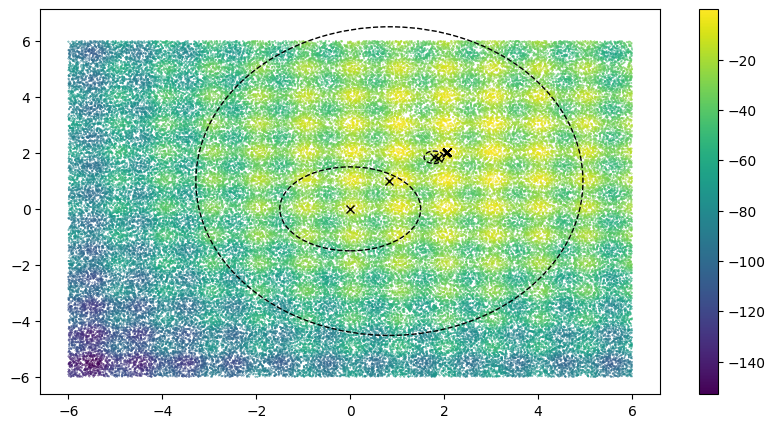

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

# sample points to show fitness landscape
x = jax.random.uniform(key, minval=-6, maxval=6, shape=(100000, 2))
f_x = fitness_func(x)

# plot fitness landscape
points = ax.scatter(x[:, 0], x[:, 1], c=f_x, s=0.1)
fig.colorbar(points)

# plot cma-es trajectory
for mean, cov in zip(means, covs):
#     print("Mean: ", mean)
#     print("Covariance: ", cov)
#     print("Covariance: ", cov[0])
#     print("Covariance: ", cov[1])
    ellipse = Ellipse((mean[0], mean[1]), cov[0, 0], cov[1, 1], fill=False, color='k', ls='--')
    ax.add_patch(ellipse)
    ax.plot(mean[0], mean[1], color='k', marker='x')

In [17]:
N = 4

pc = jnp.zeros((N,1))
ps = jnp.zeros((N,1))  # evolution paths for C and sigma
B = jnp.eye(N,N)    # B defines the coordinate system
D = jnp.ones((N,1))      # diagonal D defines the scaling
C = B * jnp.diag(D**2) * B.T     # covariance matrix C
invsqrtC = B * jnp.diag(D**(-1)) * B.T

In [18]:
pc

DeviceArray([[0.],
             [0.],
             [0.],
             [0.]], dtype=float32)

In [19]:
ps

DeviceArray([[0.],
             [0.],
             [0.],
             [0.]], dtype=float32)

In [20]:
B

DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32)

In [21]:
D

DeviceArray([[1.],
             [1.],
             [1.],
             [1.]], dtype=float32)

In [20]:
jnp.diag(D)

DeviceArray([1.], dtype=float32)

In [33]:
D**2

DeviceArray([[1.],
             [1.],
             [1.],
             [1.]], dtype=float32)

In [29]:
B * jnp.diag(D**2) * B.T

DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32)

In [30]:
B * jnp.diag(D**(-1)) * B.T

DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32)

In [34]:
C

DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32)

In [35]:
jnp.triu(C)

DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float32)

In [39]:
A = jnp.array(
[[1, 2, 3, 4],
 [5, 6, 7, 8],
 [9, 10, 11, 12],
 [13, 14, 15, 16]])

In [40]:
A

DeviceArray([[ 1,  2,  3,  4],
             [ 5,  6,  7,  8],
             [ 9, 10, 11, 12],
             [13, 14, 15, 16]], dtype=int32)

In [41]:
jnp.triu(A)

DeviceArray([[ 1,  2,  3,  4],
             [ 0,  6,  7,  8],
             [ 0,  0, 11, 12],
             [ 0,  0,  0, 16]], dtype=int32)

In [21]:
weights = jnp.array([1, 2, 3, 4, 5])
jnp.diag(weights)

DeviceArray([[1, 0, 0, 0, 0],
             [0, 2, 0, 0, 0],
             [0, 0, 3, 0, 0],
             [0, 0, 0, 4, 0],
             [0, 0, 0, 0, 5]], dtype=int32)